In [399]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import shap
from collections import defaultdict

In [400]:
cali_housing_path = '../data/California_Houses.csv'
RANDOM_SEED = 492

In [401]:
cali_df = pd.read_csv(cali_housing_path)

In [402]:
print(cali_df.head())

   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         558         219     37.85    -122.25        7768.086571   
4         565         259     37.85    -122.25        7768.086571   

   Distance_to_LA  Distance_to_SanDiego  Distance_to_SanJose  \
0   556529.158342         735501.806984         67432.5170

In [403]:
y_series = cali_df['Median_House_Value']
y = pd.DataFrame(y_series, columns=['Median_House_Value'])
features = [col for col in cali_df.columns if col != 'Median_House_Value']
X = cali_df[features]

In [404]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [405]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [406]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [407]:
subset_indices = np.random.choice(X_train.index, size=len(X_train), replace=False)

X_train_subset = X_train.loc[subset_indices]
y_train_subset = y_train.loc[subset_indices]

print(X_train_scaled.head())

   Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  Population  Households  \
0      -0.220234    0.183029  -0.505330     -0.583271   -0.625333   -0.554684   
1       1.131720   -0.453352  -0.451797     -0.319166   -0.779725   -0.428479   
2       0.635054   -0.930638   0.592095      0.475528    1.118858    0.649526   
3       0.737734   -1.248828  -0.828835     -0.968722   -0.899710   -0.977998   
4      -0.158268   -1.169280  -0.095988     -0.114544   -0.374776   -0.381152   

   Latitude  Longitude  Distance_to_coast  Distance_to_LA  \
0  1.311518  -1.639785          -0.391522        1.490960   
1  1.054222  -1.455058          -0.700199        1.220967   
2  0.764180  -1.110565          -0.144717        0.850569   
3  0.591090  -1.050653          -0.568215        0.701779   
4  1.723191  -0.296764           2.921674        1.372870   

   Distance_to_SanDiego  Distance_to_SanJose  Distance_to_SanFrancisco  
0              1.449301            -0.918829                 -1.210694  


In [408]:
X_train_subset = X_train_subset.reset_index(drop=True)
y_train_subset = y_train_subset.reset_index(drop=True)

In [409]:
X_train_tensor = tf.constant(X_train_subset.values, dtype=tf.float32)
y_train_tensor = tf.constant(y_train_subset.values, dtype=tf.float32)
print(y_train_tensor.shape)

(16512, 1)


In [435]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, subportion = 0.8, sample_method='RANDOM'): 
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subportion = subportion
        self.sample_method = sample_method
        self.estimators = []
        self.lime_explainers = []
        self.shap_explainers = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=np.random.randint(self.n_trees/5, self.n_trees+1), # self.n_trees, #
            max_depth=self.max_depth, #np.random.randint(self.max_depth/2, self.max_depth+1), # self.max_depth, # 
            validation_ratio=0.1,
            subsample=self.subportion,
            sampling_method=self.sample_method,
            random_seed=self.seed # try to set this first. Maybe this is enough
        )
        return model
    
    # if not, the number of trees/depth different for each estimator

    def fit(self, X, y):
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed)
            subset_size = int(self.subportion * len(X))
            
            # Create a subset of the dataset using sampled indices
            subset_indices = np.random.choice(X.index, size=subset_size, replace=False)
            X_train = X.loc[subset_indices].reset_index(drop=True)
            y_train = y.loc[subset_indices].reset_index(drop=True)
            
            X_tensor = tf.constant(X_train.values, dtype=tf.float32)
            y_tensor = tf.constant(y_train.values, dtype=tf.float32)
        
            
            # subset_dataset = (X_tensor, y_tensor)
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_tensor,y_tensor)
            self.estimators.append(estimator)
            
        # initiate explainers
        for model in self.estimators:
            lime_explainer = LimeTabularExplainer(X.values, feature_names=X.columns.tolist(), mode='regression')
            self.lime_explainers.append(lime_explainer)
            masker = shap.maskers.Independent(data = X_train.values)
            shap_explainer = shap.Explainer(model, masker=masker, feature_names=X.columns.tolist())
            self.shap_explainers.append(shap_explainer)
    
    #something's not right here
    def predict_mean(self, X):
        predictions = []
        
        for estimator in self.estimators:
            estimator_predictions = estimator.predict(X)  # Get predictions from the current estimator
            predictions.append(estimator_predictions)
        
        # Stack all predictions along the last axis (-1)
        predictions_stacked = tf.stack(predictions, axis=-1)
        
        # Compute mean and variance across the stacked predictions
        mean_prediction = tf.reduce_mean(predictions_stacked, axis=-1)
        sd_prediction = tf.math.reduce_std(predictions_stacked, axis=-1)
        
        return mean_prediction, sd_prediction
    
    def explain_lime(self, X):
        lime_explanations = []
        
        for estimator, explainer in zip(self.estimators, self.lime_explainers):
            for i in range(len(X)): 
                instance_explanation = explainer.explain_instance(X.iloc[i], estimator.predict, num_features=X.shape[1])
                lime_explanations.append(instance_explanation)
        return lime_explanations
    
    def explain_shap(self, X):
        shap_values = []
        
        for estimator, explainer in zip(self.estimators, self.shap_explainers):
            shap_value = explainer(X)
            shap_values.append(shap_value)
        
        return shap_values
    

In [436]:
gbt_model = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8, 
    sample_method='RANDOM'
)

In [501]:
gbt_model_50 = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8, 
    sample_method='RANDOM'
)

In [437]:
gbt_model.fit(X_train_scaled, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr8gtsht6 as temporary training directory
Reading training dataset...


[WARNING 24-06-03 16:02:21.6528 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:21.6528 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:21.6528 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.617319. Found 13209 examples.
Training model...
Model trained in 0:00:00.378103
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphgab7sxm as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:22.6502 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr8gtsht6/model/ with prefix 2aeca7e40f4d4c4a
[INFO 24-06-03 16:02:22.6526 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 16:02:22.6527 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:22.7879 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:22.7879 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:22.7879 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.287544. Found 13209 examples.
Training model...
Model trained in 0:00:00.404657
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp002g5xy_ as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:23.4806 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphgab7sxm/model/ with prefix 8b0be402c6004e66
[INFO 24-06-03 16:02:23.4820 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:23.5949 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:23.5949 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:23.5949 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.280056. Found 13209 examples.
Training model...
Model trained in 0:00:00.156704
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm2wg6l8o as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:24.0333 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp002g5xy_/model/ with prefix f71ef4921a4d4b6d
[INFO 24-06-03 16:02:24.0340 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:24.1110 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:24.1110 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:24.1111 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.271448. Found 13209 examples.
Training model...
Model trained in 0:00:00.185662
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkls3d4r0 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:24.5757 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm2wg6l8o/model/ with prefix d2d4bfc0376149a2
[INFO 24-06-03 16:02:24.5764 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:24.6611 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:24.6612 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:24.6612 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268109. Found 13209 examples.
Training model...
Model trained in 0:00:00.167112
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4zhhn2ac as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:25.0978 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkls3d4r0/model/ with prefix 42008d354727483c
[INFO 24-06-03 16:02:25.0985 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:25.1810 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:25.1810 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:25.1810 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268204. Found 13209 examples.
Training model...
Model trained in 0:00:00.154361
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_8_ueq4a as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:25.6053 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4zhhn2ac/model/ with prefix 6c873bea10ab46eb
[INFO 24-06-03 16:02:25.6060 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:25.6831 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:25.6831 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:25.6832 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272806. Found 13209 examples.
Training model...
Model trained in 0:00:00.566679
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc1q5jykn as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:26.5289 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_8_ueq4a/model/ with prefix 324a01b2a72d49af
[INFO 24-06-03 16:02:26.5308 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:26.6298 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:26.6298 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:26.6298 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.292402. Found 13209 examples.
Training model...
Model trained in 0:00:00.169057
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy3m8pj33 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:27.0928 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc1q5jykn/model/ with prefix 8e2e2bc04a534eef
[INFO 24-06-03 16:02:27.0936 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:27.2188 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:27.2188 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:27.2188 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.275621. Found 13209 examples.
Training model...
Model trained in 0:00:00.461174
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuij0071o as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:27.9563 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy3m8pj33/model/ with prefix b9e0b345d45a4158
[INFO 24-06-03 16:02:27.9579 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:28.0360 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:28.0360 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:28.0360 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268012. Found 13209 examples.
Training model...
Model trained in 0:00:00.214466
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5f4n042b as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:28.5260 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuij0071o/model/ with prefix 4564249b19714a9e
[INFO 24-06-03 16:02:28.5269 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:28.6085 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:28.6085 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:28.6085 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.262934. Found 13209 examples.
Training model...
Model trained in 0:00:00.154407
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp22f7_zba as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:29.0273 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5f4n042b/model/ with prefix 36a4c485078542b8
[INFO 24-06-03 16:02:29.0281 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:29.1108 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:29.1108 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:29.1108 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.267364. Found 13209 examples.
Training model...
Model trained in 0:00:00.183232
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfp1l5mfp as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:29.5631 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp22f7_zba/model/ with prefix ff3ed28d8ca24423
[INFO 24-06-03 16:02:29.5638 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:29.6387 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:29.6387 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:29.6387 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.266504. Found 13209 examples.
Training model...
Model trained in 0:00:00.234097
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphukiv78m as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:30.1464 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfp1l5mfp/model/ with prefix db3840d933b24f79
[INFO 24-06-03 16:02:30.1473 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:30.2269 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:30.2269 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:30.2269 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.264633. Found 13209 examples.
Training model...
Model trained in 0:00:00.453974
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpopgwiccr as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:30.9458 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphukiv78m/model/ with prefix 41156674bbc64945
[INFO 24-06-03 16:02:30.9476 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:31.0457 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:31.0457 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:31.0457 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.423209. Found 13209 examples.
Training model...
Model trained in 0:00:00.391886
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxzewp7f2 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:31.8618 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpopgwiccr/model/ with prefix 9a35064454934c4f
[INFO 24-06-03 16:02:31.8636 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:31.9627 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:31.9627 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:31.9627 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.277415. Found 13209 examples.
Training model...
Model trained in 0:00:00.236608
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpooeht7b3 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:32.4852 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxzewp7f2/model/ with prefix 869a1934142b4527
[INFO 24-06-03 16:02:32.4862 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:32.5622 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:32.5622 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:32.5622 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.274497. Found 13209 examples.
Training model...
Model trained in 0:00:00.267632
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvaeimh19 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:33.1130 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpooeht7b3/model/ with prefix 43c831d9b0bb4b7f
[INFO 24-06-03 16:02:33.1140 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 16:02:33.1140 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:33.1907 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:33.1907 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:33.1907 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.271053. Found 13209 examples.
Training model...
Model trained in 0:00:00.317875
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8vr89mpa as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:33.7878 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvaeimh19/model/ with prefix 25820e7967314c75
[INFO 24-06-03 16:02:33.7890 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:33.8611 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:33.8611 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:33.8611 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.283339. Found 13209 examples.
Training model...
Model trained in 0:00:00.112191
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdz1m3kko as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:34.2655 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8vr89mpa/model/ with prefix 6ee11d2f17f14b66
[INFO 24-06-03 16:02:34.2660 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:34.3396 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:34.3396 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:34.3396 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.281773. Found 13209 examples.
Training model...
Model trained in 0:00:00.272672
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgfhuhs8d as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:34.9024 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdz1m3kko/model/ with prefix 7ae4371610d24356
[INFO 24-06-03 16:02:34.9035 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:34.9770 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:34.9770 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:34.9770 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.289180. Found 13209 examples.
Training model...
Model trained in 0:00:00.483098
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgvejmnzn as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:35.7601 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgfhuhs8d/model/ with prefix 07fab93270f44cfc
[INFO 24-06-03 16:02:35.7621 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:35.8402 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:35.8402 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:35.8402 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.276231. Found 13209 examples.
Training model...
Model trained in 0:00:00.388932
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu47hh9_g as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:36.5131 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgvejmnzn/model/ with prefix e96ae3db9b6740ef
[INFO 24-06-03 16:02:36.5145 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:36.5900 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:36.5900 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:36.5900 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.279403. Found 13209 examples.
Training model...
Model trained in 0:00:00.184388
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjb4of1xy as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:37.0627 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu47hh9_g/model/ with prefix 4089191f306d4e2e
[INFO 24-06-03 16:02:37.0634 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:37.1392 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:37.1392 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:37.1392 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.269636. Found 13209 examples.
Training model...
Model trained in 0:00:00.137406
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp916vp7is as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:37.5557 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjb4of1xy/model/ with prefix a99be2ff1e9a4b28
[INFO 24-06-03 16:02:37.5563 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:37.6320 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:37.6321 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:37.6321 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272827. Found 13209 examples.
Training model...
Model trained in 0:00:00.315998
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvhd1zdu7 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:38.2293 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp916vp7is/model/ with prefix a9999805dc5c4fb2
[INFO 24-06-03 16:02:38.2305 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:38.3021 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:38.3021 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:38.3021 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268640. Found 13209 examples.
Training model...
Model trained in 0:00:00.329695
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpglbo_ag0 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:38.9087 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvhd1zdu7/model/ with prefix 2123125bdbb14a21
[INFO 24-06-03 16:02:38.9101 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:38.9831 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:38.9832 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:38.9832 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268064. Found 13209 examples.
Training model...
Model trained in 0:00:00.268347
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl8izy1iv as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:39.5275 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpglbo_ag0/model/ with prefix 1acb1bd2dd0a46c5
[INFO 24-06-03 16:02:39.5287 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:39.6042 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:39.6042 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:39.6042 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.266767. Found 13209 examples.
Training model...
Model trained in 0:00:00.473130
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_9idqhm9 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:40.3521 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl8izy1iv/model/ with prefix 3c6de57ffcd9467a
[INFO 24-06-03 16:02:40.3537 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:40.4254 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:40.4254 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:40.4254 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272711. Found 13209 examples.
Training model...
Model trained in 0:00:00.162646
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiwedjlrn as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:40.8696 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_9idqhm9/model/ with prefix bc17e0dc290c46e5
[INFO 24-06-03 16:02:40.8703 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:40.9422 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:40.9422 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:40.9422 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.279997. Found 13209 examples.
Training model...
Model trained in 0:00:00.269710
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxbxjzh6u as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:41.5002 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiwedjlrn/model/ with prefix d2eeea15183c4302
[INFO 24-06-03 16:02:41.5012 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:41.5787 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:41.5787 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:41.5787 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.270180. Found 13209 examples.
Training model...
Model trained in 0:00:00.408377
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvqc6pyhv as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:42.2650 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxbxjzh6u/model/ with prefix a96e8b6ab6674164
[INFO 24-06-03 16:02:42.2666 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:42.3407 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:42.3407 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:42.3407 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.280537. Found 13209 examples.
Training model...
Model trained in 0:00:00.116366
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpszzam97k as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:42.7464 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvqc6pyhv/model/ with prefix db87fabbae974732
[INFO 24-06-03 16:02:42.7470 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:42.9237 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:42.9237 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:42.9237 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.276497. Found 13209 examples.
Training model...
Model trained in 0:00:00.372369
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprn56wrxr as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:43.5813 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpszzam97k/model/ with prefix 28eab5ab7e2742e7
[INFO 24-06-03 16:02:43.5829 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 16:02:43.5829 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:43.6607 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:43.6608 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:43.6608 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.273606. Found 13209 examples.
Training model...
Model trained in 0:00:00.267997
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyzm2xlng as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:44.2113 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprn56wrxr/model/ with prefix 99168cfa869d417e
[INFO 24-06-03 16:02:44.2123 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:44.2842 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:44.2842 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:44.2842 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.271835. Found 13209 examples.
Training model...
Model trained in 0:00:00.236027
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81uc5c_x as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:44.8007 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyzm2xlng/model/ with prefix 64f9d69cda6c4a64
[INFO 24-06-03 16:02:44.8017 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:44.8744 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:44.8744 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:44.8744 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.277650. Found 13209 examples.
Training model...
Model trained in 0:00:00.304854
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbw9o8ib4 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:45.4650 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81uc5c_x/model/ with prefix e716b7272a8b411f
[INFO 24-06-03 16:02:45.4663 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:45.5381 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:45.5381 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:45.5381 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.281286. Found 13209 examples.
Training model...
Model trained in 0:00:00.179197
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptfitwg3k as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:46.0068 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbw9o8ib4/model/ with prefix e00682c8fcf3418d
[INFO 24-06-03 16:02:46.0076 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:46.0835 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:46.0836 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:46.0836 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272040. Found 13209 examples.
Training model...
Model trained in 0:00:00.353302
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ou3_vwl as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:46.7170 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptfitwg3k/model/ with prefix 5735024255e7488e
[INFO 24-06-03 16:02:46.7183 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:46.7914 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:46.7915 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:46.7915 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.275979. Found 13209 examples.
Training model...
Model trained in 0:00:00.464751
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm727fge8 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:47.5395 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ou3_vwl/model/ with prefix b72aec40782646f9
[INFO 24-06-03 16:02:47.5413 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:47.6234 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:47.6234 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:47.6234 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268228. Found 13209 examples.
Training model...
Model trained in 0:00:00.176561
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz1kzl3q8 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:48.0773 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm727fge8/model/ with prefix 1dcdbb7e9ea1463d
[INFO 24-06-03 16:02:48.0781 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:48.1522 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:48.1522 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:48.1522 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272367. Found 13209 examples.
Training model...
Model trained in 0:00:00.316746
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpunu9m4x0 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:48.7500 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz1kzl3q8/model/ with prefix 306f18718b3d4829
[INFO 24-06-03 16:02:48.7511 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:48.8244 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:48.8244 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:48.8244 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.274247. Found 13209 examples.
Training model...
Model trained in 0:00:00.476445
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpny1evt8p as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:49.5837 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpunu9m4x0/model/ with prefix 69ac00aaad174a30
[INFO 24-06-03 16:02:49.5851 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:49.6606 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:49.6606 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:49.6606 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272488. Found 13209 examples.
Training model...
Model trained in 0:00:00.390619
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1elhvse2 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:50.3321 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpny1evt8p/model/ with prefix fa7fdfeb0a5a4276
[INFO 24-06-03 16:02:50.3335 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:50.4067 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:50.4067 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:50.4067 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272229. Found 13209 examples.
Training model...
Model trained in 0:00:00.414422
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjy4qok6r as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:51.1017 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1elhvse2/model/ with prefix bc05a8e634984579
[INFO 24-06-03 16:02:51.1031 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:51.1778 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:51.1778 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:51.1778 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.271126. Found 13209 examples.
Training model...
Model trained in 0:00:00.190532
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpox3d0itm as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:51.6480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjy4qok6r/model/ with prefix 0d69ced87d634756
[INFO 24-06-03 16:02:51.6488 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:51.7223 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:51.7223 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:51.7223 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272244. Found 13209 examples.
Training model...
Model trained in 0:00:00.305719
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxyne4_1c as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:52.3089 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpox3d0itm/model/ with prefix 9ab228a4d96b4b90
[INFO 24-06-03 16:02:52.3101 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:52.3829 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:52.3829 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:52.3829 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.273438. Found 13209 examples.
Training model...
Model trained in 0:00:00.381324
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp1u3d_t7 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:53.0460 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxyne4_1c/model/ with prefix bf2b4509d8aa46f2
[INFO 24-06-03 16:02:53.0473 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:53.1228 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:53.1228 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:53.1228 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268373. Found 13209 examples.
Training model...
Model trained in 0:00:00.319639
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6rox0r3o as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:53.7197 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp1u3d_t7/model/ with prefix 065feec38e5f4c39
[INFO 24-06-03 16:02:53.7209 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 16:02:53.7209 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:53.7938 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:53.7938 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:53.7938 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.270544. Found 13209 examples.
Training model...
Model trained in 0:00:00.268603
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4n32p3ty as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:54.3416 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6rox0r3o/model/ with prefix 3c78dbc9ad194a91
[INFO 24-06-03 16:02:54.3426 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:54.4147 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:54.4148 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:54.4148 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.274809. Found 13209 examples.
Training model...
Model trained in 0:00:00.107395
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi8y_ndsw as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:54.8060 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4n32p3ty/model/ with prefix ee3a563342664f9d
[INFO 24-06-03 16:02:54.8065 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:54.8789 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:54.8789 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:54.8789 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.275290. Found 13209 examples.
Training model...
Model trained in 0:00:00.381111
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbdz27qgk as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:55.5433 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi8y_ndsw/model/ with prefix c68a79c00eaa4057
[INFO 24-06-03 16:02:55.5447 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:55.6268 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:55.6268 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:55.6268 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.270930. Found 13209 examples.
Training model...
Model trained in 0:00:00.374480
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpal9qwq4q as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:56.2729 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbdz27qgk/model/ with prefix e3bc3e50c03644a8
[INFO 24-06-03 16:02:56.2744 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:56.3481 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:56.3481 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:56.3481 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.280234. Found 13209 examples.
Training model...
Model trained in 0:00:00.464929
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2sdevdbn as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:57.0998 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpal9qwq4q/model/ with prefix 8ffd17a8a75849c1
[INFO 24-06-03 16:02:57.1015 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:57.1760 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:57.1760 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:57.1760 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.273475. Found 13209 examples.
Training model...
Model trained in 0:00:00.255174
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6gqntaz1 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:57.7124 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2sdevdbn/model/ with prefix 5aa5ad1a1b5f45c8
[INFO 24-06-03 16:02:57.7134 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:57.7863 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:57.7863 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:57.7863 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.269182. Found 13209 examples.
Training model...
Model trained in 0:00:00.403025
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_d62hgrg as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:58.4651 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6gqntaz1/model/ with prefix 9951ffe5dafe4c8e
[INFO 24-06-03 16:02:58.4666 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:58.5395 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:58.5396 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:58.5396 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.277045. Found 13209 examples.
Training model...
Model trained in 0:00:00.154862
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp61cs3rug as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:58.9791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_d62hgrg/model/ with prefix 8fe5a0010c74400e
[INFO 24-06-03 16:02:58.9797 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:59.0527 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:59.0527 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:59.0527 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.274247. Found 13209 examples.
Training model...
Model trained in 0:00:00.203692
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8yys1m9p as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:02:59.5377 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp61cs3rug/model/ with prefix 6185fa652f014b7d
[INFO 24-06-03 16:02:59.5385 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:02:59.6187 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:59.6188 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:02:59.6188 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272004. Found 13209 examples.
Training model...
Model trained in 0:00:00.422813
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpreqzw9oe as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:00.3201 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8yys1m9p/model/ with prefix 46f0d9721fe54bbf
[INFO 24-06-03 16:03:00.3217 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:00.3942 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:00.3943 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:00.3943 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.274142. Found 13209 examples.
Training model...
Model trained in 0:00:00.388424
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprhak_xf_ as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:01.0639 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpreqzw9oe/model/ with prefix a29ad3bfc2a14cd9
[INFO 24-06-03 16:03:01.0654 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:01.1406 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:01.1406 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:01.1406 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.270583. Found 13209 examples.
Training model...
Model trained in 0:00:00.290415
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbjq3ontu as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:01.7089 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprhak_xf_/model/ with prefix da49b14df2b54085
[INFO 24-06-03 16:03:01.7100 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:01.7824 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:01.7824 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:01.7824 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.270160. Found 13209 examples.
Training model...
Model trained in 0:00:00.398886
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfphi19lo as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:02.4585 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbjq3ontu/model/ with prefix 21fb5850f9f04421
[INFO 24-06-03 16:03:02.4599 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:02.5324 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:02.5324 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:02.5324 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.277060. Found 13209 examples.
Training model...
Model trained in 0:00:00.381845
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptvfny3sb as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:03.1983 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfphi19lo/model/ with prefix 256c2c0efa2c461b
[INFO 24-06-03 16:03:03.1997 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:03.2726 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:03.2726 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:03.2726 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.270047. Found 13209 examples.
Training model...
Model trained in 0:00:00.218653
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt3v9v7az as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:03.7687 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptvfny3sb/model/ with prefix c3170a357e77489f
[INFO 24-06-03 16:03:03.7695 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 16:03:03.7695 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:03.8428 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:03.8429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:03.8429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.278456. Found 13209 examples.
Training model...
Model trained in 0:00:00.118900
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp6n4z37r as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:04.2477 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt3v9v7az/model/ with prefix 1eb79ba463e742c7
[INFO 24-06-03 16:03:04.2483 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:04.3206 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:04.3206 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:04.3206 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.279040. Found 13209 examples.
Training model...
Model trained in 0:00:00.202860
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa1a9gip6 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:04.8103 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp6n4z37r/model/ with prefix dda86ca474274c18
[INFO 24-06-03 16:03:04.8111 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:04.8840 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:04.8841 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:04.8841 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.283130. Found 13209 examples.
Training model...
Model trained in 0:00:00.159635
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpig7r0g71 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:05.3346 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa1a9gip6/model/ with prefix 9753f2ed60444dc3
[INFO 24-06-03 16:03:05.3352 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:05.4083 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:05.4083 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:05.4083 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.275064. Found 13209 examples.
Training model...
Model trained in 0:00:00.108258
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzlcu_fkm as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:05.7996 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpig7r0g71/model/ with prefix eb3d1aa698b84314
[INFO 24-06-03 16:03:05.8001 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:05.8729 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:05.8729 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:05.8729 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.281728. Found 13209 examples.
Training model...
Model trained in 0:00:00.372339
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5dqcsx1c as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:06.5344 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzlcu_fkm/model/ with prefix c13a72b0d62a452a
[INFO 24-06-03 16:03:06.5358 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:06.6120 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:06.6121 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:06.6121 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.277306. Found 13209 examples.
Training model...
Model trained in 0:00:00.470514
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpztabcdk4 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:07.3670 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5dqcsx1c/model/ with prefix f97537a27cf54282
[INFO 24-06-03 16:03:07.3686 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:07.4424 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:07.4424 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:07.4424 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.278323. Found 13209 examples.
Training model...
Model trained in 0:00:00.430890
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwr9gqdy8 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:08.1585 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpztabcdk4/model/ with prefix fecade8031144645
[INFO 24-06-03 16:03:08.1600 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:08.2350 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:08.2350 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:08.2350 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.275657. Found 13209 examples.
Training model...
Model trained in 0:00:00.223236
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6fvxfpx4 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:08.7417 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwr9gqdy8/model/ with prefix 45ba5531e81e43af
[INFO 24-06-03 16:03:08.7425 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:08.8196 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:08.8196 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:08.8196 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272467. Found 13209 examples.
Training model...
Model trained in 0:00:00.250390
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqsqtt_w_ as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:09.3500 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6fvxfpx4/model/ with prefix ad1e231386f749cb
[INFO 24-06-03 16:03:09.3510 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:09.4235 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:09.4236 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:09.4236 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.274258. Found 13209 examples.
Training model...
Model trained in 0:00:00.319516
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnfy7ric5 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:10.0245 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqsqtt_w_/model/ with prefix 3b009a59b94b4413
[INFO 24-06-03 16:03:10.0257 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:10.1008 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:10.1008 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:10.1008 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.278252. Found 13209 examples.
Training model...
Model trained in 0:00:00.350494
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6xbcb0_k as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:10.7363 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnfy7ric5/model/ with prefix d634711c7a9144ae
[INFO 24-06-03 16:03:10.7375 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:10.8111 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:10.8111 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:10.8111 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.393149. Found 13209 examples.
Training model...
Model trained in 0:00:00.487214
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmz2utumn as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:11.6988 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6xbcb0_k/model/ with prefix e6d363bde0d44e1a
[INFO 24-06-03 16:03:11.7005 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:11.7758 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:11.7758 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:11.7758 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.279835. Found 13209 examples.
Training model...
Model trained in 0:00:00.284809
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpobho3l63 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:12.3477 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmz2utumn/model/ with prefix 32ecd3b9159e403a
[INFO 24-06-03 16:03:12.3488 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:12.4220 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:12.4220 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:12.4220 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.275092. Found 13209 examples.
Training model...
Model trained in 0:00:00.215188
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpslomo14d as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:12.9198 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpobho3l63/model/ with prefix 647d2356ab4e4943
[INFO 24-06-03 16:03:12.9207 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:12.9931 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:12.9931 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:12.9931 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.281572. Found 13209 examples.
Training model...
Model trained in 0:00:00.246718
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplpjoxar8 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:13.5289 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpslomo14d/model/ with prefix 8c9aaad2d23d4c7b
[INFO 24-06-03 16:03:13.5299 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:13.6035 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:13.6035 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:13.6035 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.276553. Found 13209 examples.
Training model...
Model trained in 0:00:00.236326
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvm5br2t4 as temporary training directory
Reading training dataset...


[INFO 24-06-03 16:03:14.1231 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplpjoxar8/model/ with prefix 6c0547b0f7f945d9
[INFO 24-06-03 16:03:14.1249 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 16:03:14.1250 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 16:03:14.2072 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:14.2073 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 16:03:14.2073 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.292567. Found 13209 examples.
Training model...
Model trained in 0:00:00.132485
Compiling model...
Model compiled.


[INFO 24-06-03 16:03:14.6415 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvm5br2t4/model/ with prefix d3b952f4a7d84740
[INFO 24-06-03 16:03:14.6421 CEST kernel.cc:1061] Use fast generic engine


In [502]:
X_train_subset, _, y_train_subset, _ = train_test_split(X_train_scaled, y_train, test_size=0.5, random_state=RANDOM_SEED)
gbt_model_50.fit(X_train_subset, y_train_subset)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4e5nwx6_ as temporary training directory
Reading training dataset...


[WARNING 24-06-03 17:25:54.0877 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:54.0877 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:54.0877 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.686390. Found 6604 examples.
Training model...
Model trained in 0:00:00.104009
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpju6tytu8 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:25:54.8828 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4e5nwx6_/model/ with prefix 596a243aca5f4ef0
[INFO 24-06-03 17:25:54.8835 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 17:25:54.8835 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:25:54.9603 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:54.9603 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:54.9604 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243951. Found 6604 examples.
Training model...
Model trained in 0:00:00.273984
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsx1mzxxc as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:25:55.4850 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpju6tytu8/model/ with prefix 7e3b1baeb2bc455c
[INFO 24-06-03 17:25:55.4864 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:25:55.5702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:55.5702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:55.5702 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.255456. Found 6604 examples.
Training model...
Model trained in 0:00:00.351540
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpatfvsmlg as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:25:56.1779 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsx1mzxxc/model/ with prefix 08c4fa818c15413f
[INFO 24-06-03 17:25:56.1795 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:25:56.2535 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:56.2535 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:56.2535 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248418. Found 6604 examples.
Training model...
Model trained in 0:00:00.427620
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgyunlftc as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:25:56.9357 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpatfvsmlg/model/ with prefix 3cb4b87123664481
[INFO 24-06-03 17:25:56.9375 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:25:57.0177 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:57.0177 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:57.0177 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246831. Found 6604 examples.
Training model...
Model trained in 0:00:00.218093
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx548343t as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:25:57.4843 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgyunlftc/model/ with prefix 8868fe6d0c69431b
[INFO 24-06-03 17:25:57.4853 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:25:57.5598 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:57.5598 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:57.5598 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246614. Found 6604 examples.
Training model...
Model trained in 0:00:00.235117
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbyat0k6p as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:25:58.0487 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx548343t/model/ with prefix 49e2aafb1cfc4e19
[INFO 24-06-03 17:25:58.0499 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:25:58.1263 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:58.1263 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:58.1263 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247491. Found 6604 examples.
Training model...
Model trained in 0:00:00.357621
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppi8afir3 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:25:58.7318 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbyat0k6p/model/ with prefix 7459be75dee84ce7
[INFO 24-06-03 17:25:58.7334 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:25:58.8079 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:58.8079 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:58.8079 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239203. Found 6604 examples.
Training model...
Model trained in 0:00:00.082526
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0bmt8uvw as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:25:59.1313 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppi8afir3/model/ with prefix cbecf6064f46474a
[INFO 24-06-03 17:25:59.1318 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:25:59.2016 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:59.2016 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:59.2016 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246804. Found 6604 examples.
Training model...
Model trained in 0:00:00.327091
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkisgl992 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:25:59.7817 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0bmt8uvw/model/ with prefix c6a6617f82f04c44
[INFO 24-06-03 17:25:59.7832 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:25:59.8620 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:59.8621 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:25:59.8621 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246848. Found 6604 examples.
Training model...
Model trained in 0:00:00.355344
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqqz4qvut as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:00.4648 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkisgl992/model/ with prefix 554dbda5066d4690
[INFO 24-06-03 17:26:00.4664 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:00.5433 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:00.5433 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:00.5433 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249249. Found 6604 examples.
Training model...
Model trained in 0:00:00.135670
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm1mvff5b as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:00.9299 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqqz4qvut/model/ with prefix 568920dcefb34ffc
[INFO 24-06-03 17:26:00.9306 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:01.0020 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:01.0021 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:01.0021 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239280. Found 6604 examples.
Training model...
Model trained in 0:00:00.209350
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6dqkofh7 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:01.4582 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm1mvff5b/model/ with prefix 144d0e492cc24e82
[INFO 24-06-03 17:26:01.4591 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:01.5356 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:01.5356 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:01.5356 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.254675. Found 6604 examples.
Training model...
Model trained in 0:00:00.122538
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjkt_ti6c as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:01.9144 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6dqkofh7/model/ with prefix 737d4794528f4928
[INFO 24-06-03 17:26:01.9150 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:01.9940 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:01.9940 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:01.9940 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239502. Found 6604 examples.
Training model...
Model trained in 0:00:00.104371
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu29p9v42 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:02.3396 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjkt_ti6c/model/ with prefix 0a1434cddcd74bea
[INFO 24-06-03 17:26:02.3402 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:02.4097 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:02.4097 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:02.4097 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242982. Found 6604 examples.
Training model...
Model trained in 0:00:00.197830
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpks63un84 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:02.8576 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu29p9v42/model/ with prefix e279ca68908e49ca
[INFO 24-06-03 17:26:02.8585 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:02.9338 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:02.9338 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:02.9338 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.256783. Found 6604 examples.
Training model...
Model trained in 0:00:00.283353
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprx2sqen1 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:03.4748 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpks63un84/model/ with prefix f47941d821d949cb
[INFO 24-06-03 17:26:03.4761 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:03.5536 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:03.5536 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:03.5536 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235147. Found 6604 examples.
Training model...
Model trained in 0:00:00.362265
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpudnapci_ as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:04.1517 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprx2sqen1/model/ with prefix 4e1fc54aaec24e82
[INFO 24-06-03 17:26:04.1533 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:04.2257 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:04.2258 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:04.2258 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.252777. Found 6604 examples.
Training model...
Model trained in 0:00:00.338274
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc6ur6_33 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:04.8168 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpudnapci_/model/ with prefix 8613fea48866481f
[INFO 24-06-03 17:26:04.8190 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:04.8938 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:04.8939 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:04.8939 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243440. Found 6604 examples.
Training model...
Model trained in 0:00:00.359222
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprenpjx2i as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:05.4971 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc6ur6_33/model/ with prefix 3677bd42e8d7417d
[INFO 24-06-03 17:26:05.4987 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 17:26:05.4987 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:05.5706 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:05.5706 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:05.5706 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240844. Found 6604 examples.
Training model...
Model trained in 0:00:00.333473
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk7svho36 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:06.1512 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprenpjx2i/model/ with prefix 6bdc92eadafe48d3
[INFO 24-06-03 17:26:06.1527 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:06.2243 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:06.2243 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:06.2243 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.255377. Found 6604 examples.
Training model...
Model trained in 0:00:00.140202
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5mst9395 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:06.6276 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk7svho36/model/ with prefix b63514f6696d4dc2
[INFO 24-06-03 17:26:06.6282 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:06.6989 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:06.6989 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:06.6989 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242362. Found 6604 examples.
Training model...
Model trained in 0:00:00.348355
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7dgm5693 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:07.2958 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5mst9395/model/ with prefix 93186d72dbde4932
[INFO 24-06-03 17:26:07.2976 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:07.3682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:07.3683 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:07.3683 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.256875. Found 6604 examples.
Training model...
Model trained in 0:00:00.085775
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8y8h4qm9 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:07.7181 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7dgm5693/model/ with prefix e8870570de8a4e72
[INFO 24-06-03 17:26:07.7187 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:07.7890 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:07.7891 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:07.7891 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.278050. Found 6604 examples.
Training model...
Model trained in 0:00:00.224866
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvnqenc5a as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:08.2989 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8y8h4qm9/model/ with prefix 49d4cc88bbeb4cd8
[INFO 24-06-03 17:26:08.2999 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:08.3702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:08.3702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:08.3702 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240135. Found 6604 examples.
Training model...
Model trained in 0:00:00.344476
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qeob8b9 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:08.9610 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvnqenc5a/model/ with prefix ac9d55497b344694
[INFO 24-06-03 17:26:08.9628 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:09.0327 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:09.0327 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:09.0327 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249130. Found 6604 examples.
Training model...
Model trained in 0:00:00.114717
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn855r7jn as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:09.4044 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qeob8b9/model/ with prefix 9f7b186e02954e9a
[INFO 24-06-03 17:26:09.4051 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:09.4779 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:09.4780 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:09.4780 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249131. Found 6604 examples.
Training model...
Model trained in 0:00:00.241640
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps98bvmuq as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:09.9758 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn855r7jn/model/ with prefix 21d1687a12a848ec
[INFO 24-06-03 17:26:09.9770 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:10.0473 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:10.0473 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:10.0474 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236889. Found 6604 examples.
Training model...
Model trained in 0:00:00.301955
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc5sldhn4 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:10.5929 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps98bvmuq/model/ with prefix bdbdd9aa62ae4a61
[INFO 24-06-03 17:26:10.5942 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:10.6655 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:10.6655 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:10.6655 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.346119. Found 6604 examples.
Training model...
Model trained in 0:00:00.323910
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt_dds_nb as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:11.3427 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc5sldhn4/model/ with prefix 31d7266d7fe64848
[INFO 24-06-03 17:26:11.3439 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:11.4150 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:11.4150 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:11.4150 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245779. Found 6604 examples.
Training model...
Model trained in 0:00:00.112110
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcs0yjp_t as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:11.7802 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt_dds_nb/model/ with prefix fcc11608e5f24ee4
[INFO 24-06-03 17:26:11.7808 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:11.8665 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:11.8665 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:11.8665 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250944. Found 6604 examples.
Training model...
Model trained in 0:00:00.099041
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_6an3t5v as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:12.2240 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcs0yjp_t/model/ with prefix 2069249cf84f4cb1
[INFO 24-06-03 17:26:12.2245 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:12.2958 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:12.2958 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:12.2958 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.251154. Found 6604 examples.
Training model...
Model trained in 0:00:00.108133
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpho8ris9t as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:12.6625 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_6an3t5v/model/ with prefix 79a1e608ff5844e3
[INFO 24-06-03 17:26:12.6631 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:12.7323 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:12.7323 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:12.7323 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245247. Found 6604 examples.
Training model...
Model trained in 0:00:00.370885
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz1s1ufv1 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:13.3549 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpho8ris9t/model/ with prefix 57b4f26f31fb4ff3
[INFO 24-06-03 17:26:13.3566 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:13.4274 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:13.4274 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:13.4274 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244905. Found 6604 examples.
Training model...
Model trained in 0:00:00.180440
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpba49q_8y as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:13.8602 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz1s1ufv1/model/ with prefix f1d9697616624822
[INFO 24-06-03 17:26:13.8611 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:13.9330 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:13.9331 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:13.9331 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246591. Found 6604 examples.
Training model...
Model trained in 0:00:00.082663
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2a81hplt as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:14.2697 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpba49q_8y/model/ with prefix d996242864b2450e
[INFO 24-06-03 17:26:14.2701 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:14.3411 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:14.3411 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:14.3411 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247553. Found 6604 examples.
Training model...
Model trained in 0:00:00.242474
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2kt7cgfi as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:14.8380 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2a81hplt/model/ with prefix d9897df308154762
[INFO 24-06-03 17:26:14.8392 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:14.9104 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:14.9104 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:14.9104 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246466. Found 6604 examples.
Training model...
Model trained in 0:00:00.221176
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp42tdyckh as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:15.3849 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2kt7cgfi/model/ with prefix eadc785248c4440b
[INFO 24-06-03 17:26:15.3859 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:15.4564 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:15.4564 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:15.4564 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244644. Found 6604 examples.
Training model...
Model trained in 0:00:00.238993
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5fcj7qbu as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:15.9469 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp42tdyckh/model/ with prefix 5972a60fdd5b454a
[INFO 24-06-03 17:26:15.9480 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 17:26:15.9480 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:16.0193 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:16.0193 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:16.0193 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245421. Found 6604 examples.
Training model...
Model trained in 0:00:00.176321
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb9x778h6 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:16.4482 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5fcj7qbu/model/ with prefix 7ecad4eaaa224b02
[INFO 24-06-03 17:26:16.4491 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:16.5193 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:16.5193 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:16.5193 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.252515. Found 6604 examples.
Training model...
Model trained in 0:00:00.342270
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq49ygjil as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:17.1208 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb9x778h6/model/ with prefix 56c05d70b05c492f
[INFO 24-06-03 17:26:17.1224 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:17.2077 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:17.2077 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:17.2077 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246263. Found 6604 examples.
Training model...
Model trained in 0:00:00.311946
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmufttvgr as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:17.7724 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq49ygjil/model/ with prefix 1741ad34c2cc450f
[INFO 24-06-03 17:26:17.7740 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:17.8454 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:17.8454 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:17.8454 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245254. Found 6604 examples.
Training model...
Model trained in 0:00:00.193307
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6uobq_kv as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:18.2912 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmufttvgr/model/ with prefix 5e173c8779604587
[INFO 24-06-03 17:26:18.2922 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:18.3643 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:18.3643 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:18.3643 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244813. Found 6604 examples.
Training model...
Model trained in 0:00:00.161968
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1k4ld4pq as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:18.7784 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6uobq_kv/model/ with prefix 53c09267d0f94fc4
[INFO 24-06-03 17:26:18.7793 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:18.8546 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:18.8546 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:18.8546 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.251724. Found 6604 examples.
Training model...
Model trained in 0:00:00.174089
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_9lcvopm as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:19.2877 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1k4ld4pq/model/ with prefix 692adf76d833449b
[INFO 24-06-03 17:26:19.2886 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:19.3627 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:19.3628 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:19.3628 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247858. Found 6604 examples.
Training model...
Model trained in 0:00:00.239598
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp55xeoi96 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:19.8572 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_9lcvopm/model/ with prefix 17c8c01c342c4308
[INFO 24-06-03 17:26:19.8583 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:19.9310 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:19.9310 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:19.9310 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.256656. Found 6604 examples.
Training model...
Model trained in 0:00:00.094065
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphhm8rd94 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:20.2895 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp55xeoi96/model/ with prefix 48c78befeee74591
[INFO 24-06-03 17:26:20.2900 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:20.3637 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:20.3637 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:20.3637 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.262075. Found 6604 examples.
Training model...
Model trained in 0:00:00.150236
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp126n01y_ as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:20.7832 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphhm8rd94/model/ with prefix 43efab8cc250403f
[INFO 24-06-03 17:26:20.7840 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:20.8539 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:20.8539 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:20.8539 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.259480. Found 6604 examples.
Training model...
Model trained in 0:00:00.282971
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_uf73k65 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:21.4032 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp126n01y_/model/ with prefix fdc2dfffa8884b92
[INFO 24-06-03 17:26:21.4046 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:21.4762 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:21.4763 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:21.4763 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250975. Found 6604 examples.
Training model...
Model trained in 0:00:00.250156
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg23q2avt as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:21.9848 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_uf73k65/model/ with prefix 19b9a34020d74295
[INFO 24-06-03 17:26:21.9860 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:22.0633 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:22.0634 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:22.0634 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260779. Found 6604 examples.
Training model...
Model trained in 0:00:00.116250
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm618yqci as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:22.4483 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg23q2avt/model/ with prefix f2e9ed5f0f464bc6
[INFO 24-06-03 17:26:22.4489 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:22.5226 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:22.5227 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:22.5227 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250444. Found 6604 examples.
Training model...
Model trained in 0:00:00.308323
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpskp3yu4q as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:23.0879 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm618yqci/model/ with prefix db97699ddde1491a
[INFO 24-06-03 17:26:23.0895 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:23.1605 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:23.1605 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:23.1605 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247611. Found 6604 examples.
Training model...
Model trained in 0:00:00.162594
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ms8iiqc as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:23.5783 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpskp3yu4q/model/ with prefix a69c29938a334b73
[INFO 24-06-03 17:26:23.5791 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:23.6555 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:23.6555 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:23.6555 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244889. Found 6604 examples.
Training model...
Model trained in 0:00:00.385656
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmr3doams as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:24.2924 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ms8iiqc/model/ with prefix afb43f9309e3444d
[INFO 24-06-03 17:26:24.2939 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:24.3670 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:24.3670 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:24.3670 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250859. Found 6604 examples.
Training model...
Model trained in 0:00:00.322674
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcf_f2ti_ as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:24.9473 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmr3doams/model/ with prefix 3fedd5032a42497f
[INFO 24-06-03 17:26:24.9489 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:25.0232 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:25.0233 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:25.0233 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245875. Found 6604 examples.
Training model...
Model trained in 0:00:00.325134
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6krqjac6 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:25.6010 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcf_f2ti_/model/ with prefix c214476589a44ae8
[INFO 24-06-03 17:26:25.6024 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:25.6734 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:25.6734 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:25.6734 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250211. Found 6604 examples.
Training model...
Model trained in 0:00:00.361166
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6vbrgpx_ as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:26.2915 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6krqjac6/model/ with prefix a59cf6fcb1fd4b4b
[INFO 24-06-03 17:26:26.2931 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 17:26:26.2931 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:26.3635 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:26.3635 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:26.3635 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.261578. Found 6604 examples.
Training model...
Model trained in 0:00:00.276135
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeopz5lpo as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:26.9081 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6vbrgpx_/model/ with prefix c1c2818166cc4a25
[INFO 24-06-03 17:26:26.9094 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:26.9868 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:26.9868 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:26.9869 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.255556. Found 6604 examples.
Training model...
Model trained in 0:00:00.233886
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5v5wqkui as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:27.4835 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeopz5lpo/model/ with prefix ad04f45d8d2049f5
[INFO 24-06-03 17:26:27.4846 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:27.5644 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:27.5644 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:27.5644 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.259059. Found 6604 examples.
Training model...
Model trained in 0:00:00.116288
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50llb_y0 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:27.9474 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5v5wqkui/model/ with prefix aff8a5381c4a4846
[INFO 24-06-03 17:26:27.9480 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:28.0341 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:28.0341 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:28.0341 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.258054. Found 6604 examples.
Training model...
Model trained in 0:00:00.105423
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp537vpt3h as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:28.4057 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50llb_y0/model/ with prefix f7226dea21e44022
[INFO 24-06-03 17:26:28.4063 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:28.4833 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:28.4833 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:28.4833 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260673. Found 6604 examples.
Training model...
Model trained in 0:00:00.212987
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk9tg3ppv as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:28.9647 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp537vpt3h/model/ with prefix c6b7f312c7f240a3
[INFO 24-06-03 17:26:28.9658 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:29.0409 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:29.0409 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:29.0409 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.263402. Found 6604 examples.
Training model...
Model trained in 0:00:00.192536
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzalav8hx as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:29.5044 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk9tg3ppv/model/ with prefix a1032be0d0c44ff1
[INFO 24-06-03 17:26:29.5053 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:29.5941 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:29.5941 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:29.5941 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.292771. Found 6604 examples.
Training model...
Model trained in 0:00:00.185467
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2qkjynku as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:30.0819 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzalav8hx/model/ with prefix 55a55b79635d45a5
[INFO 24-06-03 17:26:30.0828 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:30.1683 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:30.1684 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:30.1684 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.349934. Found 6604 examples.
Training model...
Model trained in 0:00:00.333095
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsmse53gv as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:30.8597 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2qkjynku/model/ with prefix 0b66d2be500b484b
[INFO 24-06-03 17:26:30.8610 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:30.9420 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:30.9420 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:30.9420 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.278536. Found 6604 examples.
Training model...
Model trained in 0:00:00.135655
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzuzvua6r as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:31.3645 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsmse53gv/model/ with prefix 80ab22c8eef641be
[INFO 24-06-03 17:26:31.3652 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:31.4456 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:31.4456 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:31.4456 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.265105. Found 6604 examples.
Training model...
Model trained in 0:00:00.230943
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm0rnbzal as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:31.9485 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzuzvua6r/model/ with prefix e7da746798f342dc
[INFO 24-06-03 17:26:31.9500 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:32.0340 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:32.0340 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:32.0340 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.263139. Found 6604 examples.
Training model...
Model trained in 0:00:00.089466
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpag7rvzag as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:32.3948 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm0rnbzal/model/ with prefix 7d9d9b91026642d7
[INFO 24-06-03 17:26:32.3953 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:32.4745 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:32.4745 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:32.4745 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.270127. Found 6604 examples.
Training model...
Model trained in 0:00:00.352156
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp36tul52p as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:33.1046 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpag7rvzag/model/ with prefix 7d6641d02ced4b14
[INFO 24-06-03 17:26:33.1063 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:33.1888 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:33.1888 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:33.1888 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.261853. Found 6604 examples.
Training model...
Model trained in 0:00:00.226412
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcfqcnn16 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:33.6861 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp36tul52p/model/ with prefix ce9cb87852e9489f
[INFO 24-06-03 17:26:33.6871 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:33.7649 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:33.7650 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:33.7650 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.261479. Found 6604 examples.
Training model...
Model trained in 0:00:00.112825
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_ujfn3_ as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:34.1476 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcfqcnn16/model/ with prefix 7425dad312cd49ca
[INFO 24-06-03 17:26:34.1482 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:34.2357 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:34.2357 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:34.2357 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.262301. Found 6604 examples.
Training model...
Model trained in 0:00:00.136933
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphmb7icj5 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:34.6427 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_ujfn3_/model/ with prefix 96b243359ff84fa8
[INFO 24-06-03 17:26:34.6434 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:34.7252 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:34.7253 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:34.7253 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.262256. Found 6604 examples.
Training model...
Model trained in 0:00:00.179932
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnpr431r2 as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:35.1755 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphmb7icj5/model/ with prefix d1fb288c33db42c5
[INFO 24-06-03 17:26:35.1763 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:35.2856 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:35.2857 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:35.2857 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.279931. Found 6604 examples.
Training model...
Model trained in 0:00:00.230610
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxe8_vf1p as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:35.8063 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnpr431r2/model/ with prefix cb2a20562ef84dc9
[INFO 24-06-03 17:26:35.8073 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:35.8828 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:35.8828 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:35.8828 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260768. Found 6604 examples.
Training model...
Model trained in 0:00:00.304974
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpklahjehn as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:36.4556 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxe8_vf1p/model/ with prefix 1544f6f1f23f4d97
[INFO 24-06-03 17:26:36.4570 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-06-03 17:26:36.4570 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:36.5331 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:36.5331 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:36.5331 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260781. Found 6604 examples.
Training model...
Model trained in 0:00:00.172090
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfc00_i7g as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:36.9737 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpklahjehn/model/ with prefix f4fdc25b38684829
[INFO 24-06-03 17:26:36.9746 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:37.0536 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:37.0536 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:37.0536 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.263063. Found 6604 examples.
Training model...
Model trained in 0:00:00.351003
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplc67cexu as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:37.6746 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfc00_i7g/model/ with prefix 0bb50e22ed9d4ae3
[INFO 24-06-03 17:26:37.6761 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:37.7509 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:37.7509 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:37.7509 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.252814. Found 6604 examples.
Training model...
Model trained in 0:00:00.173411
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9oshpuj as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:38.1846 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplc67cexu/model/ with prefix 75567095c8a14e59
[INFO 24-06-03 17:26:38.1855 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:38.2628 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:38.2629 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:38.2629 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.258631. Found 6604 examples.
Training model...
Model trained in 0:00:00.282106
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj7hnkiap as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:38.8110 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9oshpuj/model/ with prefix 31004e7cc8c94e20
[INFO 24-06-03 17:26:38.8123 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:38.8883 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:38.8883 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:38.8883 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.261391. Found 6604 examples.
Training model...
Model trained in 0:00:00.308213
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcuh3p2za as temporary training directory
Reading training dataset...


[INFO 24-06-03 17:26:39.4649 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj7hnkiap/model/ with prefix ac9e6d383e8349b9
[INFO 24-06-03 17:26:39.4663 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-03 17:26:39.5407 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:39.5407 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-03 17:26:39.5407 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.259676. Found 6604 examples.
Training model...
Model trained in 0:00:00.359068
Compiling model...
Model compiled.


[INFO 24-06-03 17:26:40.1661 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcuh3p2za/model/ with prefix 2401c4cbed8f4ea4
[INFO 24-06-03 17:26:40.1679 CEST kernel.cc:1061] Use fast generic engine


In [438]:
mean_predict, variance_predict = gbt_model.predict_mean(X_test_scaled)

129/129 [==============================] - 0s 523us/step


In [503]:
mean_predict_50, sd_predict_50 = gbt_model_50.predict_mean(X_test_scaled)

129/129 [==============================] - 0s 605us/step


In [439]:
y_test_eval = np.array(y_test).flatten()
y_pred_eval = mean_predict.numpy().flatten()

In [441]:
root_mse = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval))
print(root_mse)

61773.95131837605


In [504]:
y_pred_eval_50 = mean_predict.numpy().flatten()
root_mse_50 = np.sqrt(mean_squared_error(y_test_eval, y_pred_eval_50))
print(root_mse)

61773.95131837605


In [505]:
indices_max = tf.where(tf.equal(variance_predict, max(variance_predict)))
index_max_uncertainty = indices_max[0][0]
indices_min = tf.where(tf.equal(variance_predict, min(variance_predict)))
index_min_uncertainty = indices_min[0][0]
print(index_max_uncertainty)

tf.Tensor(128, shape=(), dtype=int64)


In [506]:
indices_max_50 = tf.where(tf.equal(sd_predict_50, max(sd_predict_50)))
index_max_uncertainty_50 = indices_max[0][0]
indices_min = tf.where(tf.equal(sd_predict_50, min(sd_predict_50)))
index_min_uncertainty_50 = indices_min[0][0]
print(index_max_uncertainty_50)

tf.Tensor(128, shape=(), dtype=int64)


In [171]:
y_plot_m = [y_test[index_min_uncertainty],y_test[index_max_uncertainty]]
x_axis = np.arange(len(y_plot_m))
y_mean_predict_m = [mean_predict[index_min_uncertainty], mean_predict[index_max_uncertainty]]
y_std_predict_m = [variance_predict[index_min_uncertainty],variance_predict[index_max_uncertainty]]

InvalidIndexError: tf.Tensor(2886, shape=(), dtype=int64)

In [518]:
PLOT = 30

In [524]:
y_plot = y_test[:PLOT]
x_axis = np.arange(len(y_plot))
y_mean_predict = mean_predict[:PLOT].numpy()
y_var_predict = variance_predict[:PLOT].numpy()

y_50_mean_predict = mean_predict_50[:PLOT].numpy()
y_50_sd_predict = sd_predict_50[:PLOT].numpy()

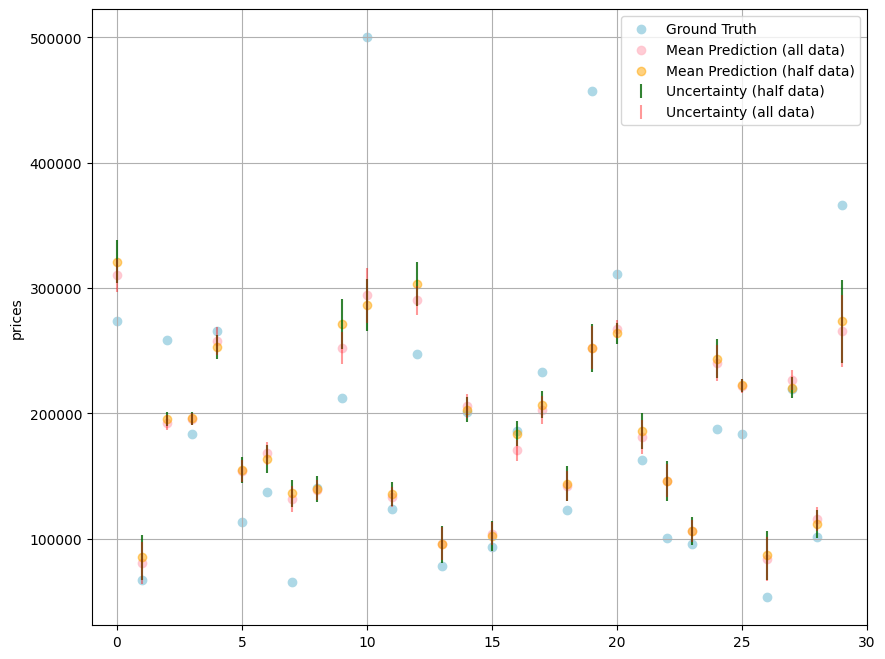

In [532]:
plt.figure(figsize=(10, 8))
plt.xlim(-1,PLOT)
plt.scatter(x_axis, y_plot, color='lightblue', label="Ground Truth")
plt.scatter(x_axis, y_mean_predict.flatten(), color='pink', alpha=0.8, label='Mean Prediction (all data)')
# plt.errorbar(x_axis, y_mean_predict.flatten(), yerr=root_mse, fmt='none', ecolor='pink', label="Root MSE (all data)")

plt.scatter(x_axis, y_50_mean_predict.flatten(), color='orange', alpha=0.5, label='Mean Prediction (half data)')
# plt.errorbar(x_axis, y_50_mean_predict.flatten(), yerr=root_mse_50, fmt='none', ecolor='yellow', alpha=0.6, label="Root MSE (half data)")


plt.errorbar(x_axis, y_50_mean_predict.flatten(), yerr=y_50_sd_predict.flatten(), fmt='none', color='darkgreen', alpha=0.8, label="Uncertainty (half data)")
plt.errorbar(x_axis, y_mean_predict.flatten(), yerr=y_var_predict.flatten(), fmt='none', color='red', alpha=0.4, label="Uncertainty (all data)")

plt.ylabel('prices')
plt.legend()
plt.grid(True)  # Enable grid for better visualization
plt.show()

In [445]:
# find the data points with the largest and smallest difference

In [490]:
print(y_test.loc[[128]])

     Median_House_Value
128            500001.0


In [491]:
gbt_explanation_lime = gbt_model.explain_lime(X_test.loc[[128]])

 41/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 14s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 41/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 44/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 75/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 76/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 70/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 69/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 67/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 63/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 69/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 64/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 49/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 59/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 73/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 72/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 77/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 80/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 74/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 61/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 75/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 66/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 81/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 82/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 81/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 64/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 53/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 14s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 59/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 72/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 72/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 61/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 58/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 72/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 51/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 71/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 27/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 62/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 75/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 76/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 79/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 53/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 75/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 88/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 81/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 76/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 80/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 71/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 80/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 38/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 61/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 68/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 28/157 [====>.........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 65/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 29/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 16s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 43/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 28/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 56/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 64/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 59/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 76/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 70/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 76/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 69/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 63/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 77/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 59/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 86/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 67/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

In [507]:
gbt_explanation_50_lime = gbt_model_50.explain_lime(X_test.loc[[128]])

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ trea

 43/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 17s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 13s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 14s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 13s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 33/157 [=====>........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 49/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 43/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 41/157 [======>.......................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 29/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 6s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 42/157 [=======>......................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 70/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 9s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 21/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 23/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 24/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 26/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 44/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 29/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 5s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 11s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 14/157 [=>............................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 27/157 [====>.........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 44/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 27/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 7s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 38/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 35/157 [=====>........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 10s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 28/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 40/157 [======>.......................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 46/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 34/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 34/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 12s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 42/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 13s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 42/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 6s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 34/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 36/157 [=====>........................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 88/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 32/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 27/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 42/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 34/157 [=====>........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 44/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 6s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 8s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

  1/157 [..............................] - ETA: 13s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 39/157 [======>.......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

In [492]:
print(X_test.loc[[128]])

     Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  Population  \
128         4.2042          52       3219           969        1152   

     Households  Latitude  Longitude  Distance_to_coast  Distance_to_LA  \
128         830     37.79    -122.43         1634.62373   560978.041154   

     Distance_to_SanDiego  Distance_to_SanJose  Distance_to_SanFrancisco  
128         739479.269432         69241.813972               1785.873518  


In [493]:
gbt_explanation_shap=gbt_model.explain_shap(X_test.loc[[128]])

In [508]:
gbt_explanation_50_shap=gbt_model_50.explain_shap(X_test.loc[[128]])

In [494]:
for i, explanation in enumerate(gbt_explanation_lime):
    print(f"Explanation {i + 1}:")
    print("As List of Tuples (feature_id, weight):")
    for feature_id, weight in explanation.as_list():
        print(f"Feature {feature_id}: {weight}")

    print("\n")

Explanation 1:
As List of Tuples (feature_id, weight):
Feature Median_Income > 0.46: 149184.2794693192
Feature Distance_to_coast > 0.19: -69637.81124830684
Feature Latitude > 0.97: -23096.71443751593
Feature Median_Age > 0.66: 11348.49122767892
Feature Distance_to_LA > 1.04: -9719.161973100452
Feature Tot_Rooms > 0.24: 9399.89909286463
Feature Distance_to_SanJose > 0.77: -8539.528215804867
Feature Population > 0.27: -6485.960711821462
Feature Distance_to_SanFrancisco > 0.79: -3983.15911193899
Feature Longitude <= -1.11: 3720.4110487944804
Feature Tot_Bedrooms > 0.26: 3080.3531823161584
Feature Households > 0.28: 1004.6006516798277
Feature Distance_to_SanDiego > 1.06: 814.1424098721277


Explanation 2:
As List of Tuples (feature_id, weight):
Feature Median_Income > 0.46: 150671.50807017693
Feature Distance_to_coast > 0.19: -67317.66886638288
Feature Latitude > 0.97: -25033.427404391077
Feature Tot_Bedrooms > 0.26: 11552.40938738447
Feature Distance_to_LA > 1.04: -11191.447276435612
Feat

In [495]:
print(gbt_explanation_shap[0].values)

[[196885.07527778   6386.36630642   7266.45234484   3585.21985352
   -4433.51674154   2201.91632921 -11604.45172743   6745.45764865
  -83055.5076161   -7430.04786133    317.54682943  -3381.13583984
   -9428.95816298]]


In [496]:
feature_weights = defaultdict(list)

for explanation in gbt_explanation_lime:
    for feature, weight in explanation.as_list():
        feature_weights[feature].append(weight)

feature_stats = {}
for feature, weights in feature_weights.items():
    mean_weight = np.mean(weights)
    std_weight = np.std(weights)
    feature_stats[feature] = {'mean': mean_weight, 'std': std_weight}

print(feature_stats)

{'Median_Income > 0.46': {'mean': 144164.01507942245, 'std': 11521.471290379955}, 'Distance_to_coast > 0.19': {'mean': -66770.87819637779, 'std': 6507.236802980988}, 'Latitude > 0.97': {'mean': -21931.637921128025, 'std': 7732.936826643494}, 'Median_Age > 0.66': {'mean': 8193.214887066017, 'std': 1804.278573478916}, 'Distance_to_LA > 1.04': {'mean': -11111.381030355264, 'std': 4608.743843267504}, 'Tot_Rooms > 0.24': {'mean': 4160.792270365359, 'std': 4672.713373229236}, 'Distance_to_SanJose > 0.77': {'mean': -6579.7505488153665, 'std': 2760.9964444587586}, 'Population > 0.27': {'mean': -5867.207381557096, 'std': 5548.248307744061}, 'Distance_to_SanFrancisco > 0.79': {'mean': -3688.7598285921877, 'std': 2530.973864500976}, 'Longitude <= -1.11': {'mean': 4823.7069951649155, 'std': 4271.635024003495}, 'Tot_Bedrooms > 0.26': {'mean': 7184.517263288042, 'std': 5126.7019746362685}, 'Households > 0.28': {'mean': 1161.6593958243075, 'std': 1997.790205077412}, 'Distance_to_SanDiego > 1.06': {'m

In [510]:
feature_order = X_test.columns.tolist()
def sort_key(x):
    for op in [' >= ', ' <= ', ' > ', ' < ', ' = ']:
        if op in x:
            return feature_order.index(x.split(op)[0])
        
sorted_keys = sorted(feature_stats.keys(), key=sort_key)
sorted_feature_stats = {key: feature_stats[key] for key in sorted_keys}

print(sorted_feature_stats)

{'Median_Income > 0.46': {'mean': 144164.01507942245, 'std': 11521.471290379955}, 'Median_Age > 0.66': {'mean': 8193.214887066017, 'std': 1804.278573478916}, 'Tot_Rooms > 0.24': {'mean': 4160.792270365359, 'std': 4672.713373229236}, 'Tot_Bedrooms > 0.26': {'mean': 7184.517263288042, 'std': 5126.7019746362685}, 'Population > 0.27': {'mean': -5867.207381557096, 'std': 5548.248307744061}, 'Households > 0.28': {'mean': 1161.6593958243075, 'std': 1997.790205077412}, 'Latitude > 0.97': {'mean': -21931.637921128025, 'std': 7732.936826643494}, 'Longitude <= -1.11': {'mean': 4823.7069951649155, 'std': 4271.635024003495}, 'Distance_to_coast > 0.19': {'mean': -66770.87819637779, 'std': 6507.236802980988}, 'Distance_to_LA > 1.04': {'mean': -11111.381030355264, 'std': 4608.743843267504}, 'Distance_to_SanDiego > 1.06': {'mean': 2113.7049150306175, 'std': 2156.4387713091946}, 'Distance_to_SanJose > 0.77': {'mean': -6579.7505488153665, 'std': 2760.9964444587586}, 'Distance_to_SanFrancisco > 0.79': {'m

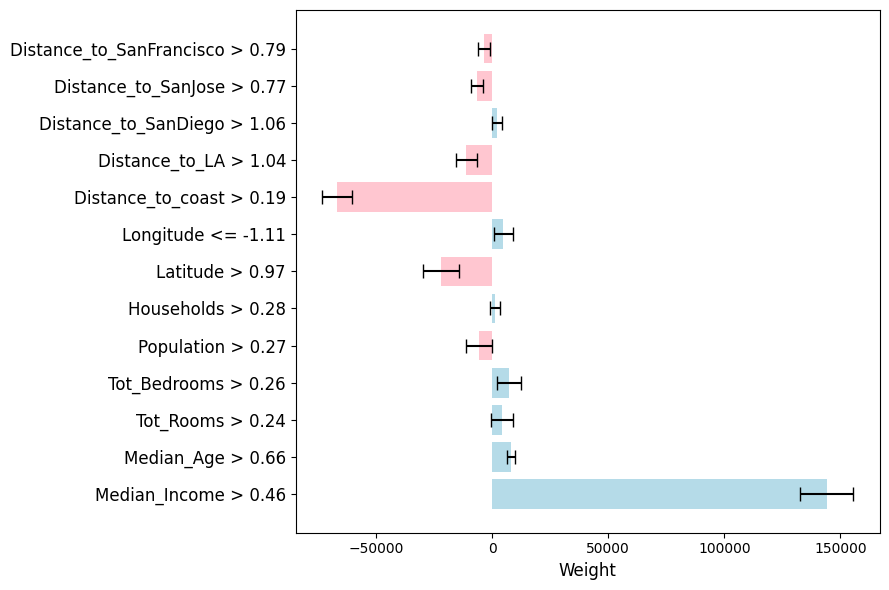

weights [144164.01507942245, 8193.214887066017, 4160.792270365359, 7184.517263288042, -5867.207381557096, 1161.6593958243075, -21931.637921128025, 4823.7069951649155, -66770.87819637779, -11111.381030355264, 2113.7049150306175, -6579.7505488153665, -3688.7598285921877] sd [11521.471290379955, 1804.278573478916, 4672.713373229236, 5126.7019746362685, 5548.248307744061, 1997.790205077412, 7732.936826643494, 4271.635024003495, 6507.236802980988, 4608.743843267504, 2156.4387713091946, 2760.9964444587586, 2530.973864500976]


In [514]:
features = list(sorted_feature_stats.keys())
mean_weights = [sorted_feature_stats[feature]['mean'] for feature in features]
std_weights = [sorted_feature_stats[feature]['std'] for feature in features]

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_weights]

feature_ids = range(len(mean_weights))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_weights, xerr=std_weights, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, features, fontsize=12)
plt.xlabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

print("weights", mean_weights, "sd", std_weights)

In [499]:
stacked_shap_values = np.vstack([gbt_explanation_shap[i].values for i in range(len(gbt_explanation_shap))])
mean_shap_values = np.mean(stacked_shap_values, axis=0)
sd_shap_values = np.std(stacked_shap_values, axis=0)
shap_features = X_test.loc[[10]].columns.tolist()

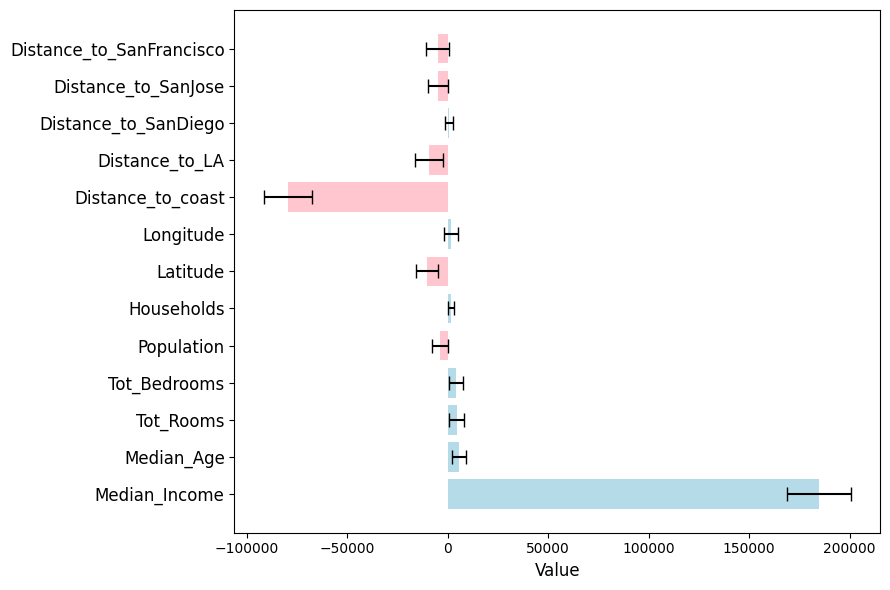

In [500]:

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_shap_values]

feature_ids = range(len(mean_shap_values))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_shap_values, xerr=sd_shap_values, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, shap_features, fontsize=12)
plt.xlabel("Value", fontsize=12)
plt.tight_layout()
plt.show()

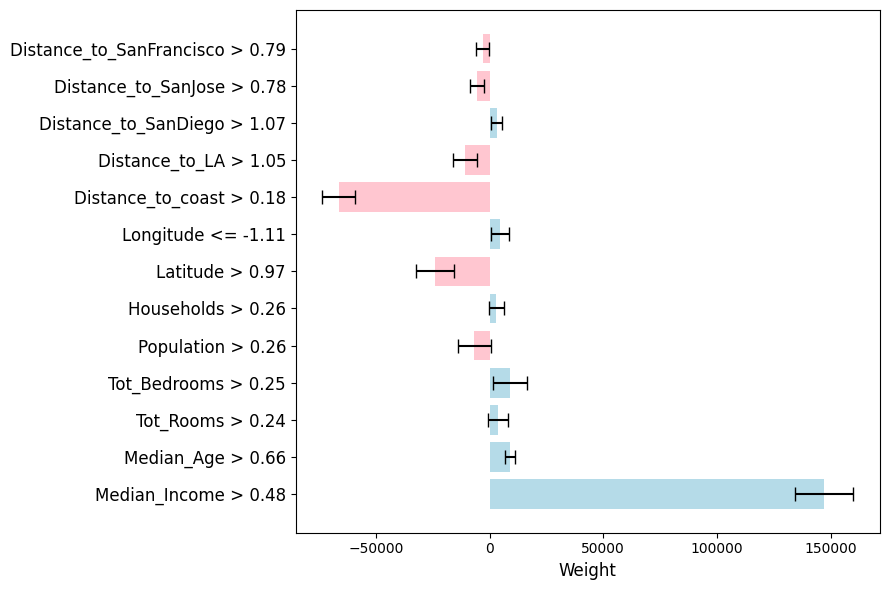

weights [147322.2814157158, 9073.733996703737, 3747.2309686772146, 9061.894527867013, -6685.131287430113, 3048.0729391770487, -24001.574454682122, 4737.7961515629295, -66399.7486207813, -10901.489080048617, 3162.955373532286, -5392.960946836957, -3062.9405257789176] sd [12762.74227910607, 2050.3825289397264, 4400.046221064201, 7397.483390176069, 7300.73875984712, 3442.376718567521, 8518.96069571447, 4017.9060762322283, 7154.698161803943, 5224.584025643989, 2296.388669912313, 2977.895616481192, 2795.1943269493836]


In [515]:
feature_weights_50 = defaultdict(list)

for explanation in gbt_explanation_50_lime:
    for feature, weight in explanation.as_list():
        feature_weights_50[feature].append(weight)

feature_stats_50 = {}
for feature, weights in feature_weights_50.items():
    mean_weight_50 = np.mean(weights)
    std_weight_50 = np.std(weights)
    feature_stats_50[feature] = {'mean': mean_weight_50, 'std': std_weight_50}

sorted_keys_50 = sorted(feature_stats_50.keys(), key=sort_key)
sorted_feature_stats_50 = {key: feature_stats_50[key] for key in sorted_keys_50}

features = list(sorted_feature_stats_50.keys())
mean_weights = [sorted_feature_stats_50[feature]['mean'] for feature in features]
std_weights = [sorted_feature_stats_50[feature]['std'] for feature in features]

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_weights]

feature_ids = range(len(mean_weights))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_weights, xerr=std_weights, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, features, fontsize=12)
plt.xlabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

print("weights", mean_weights, "sd", std_weights)

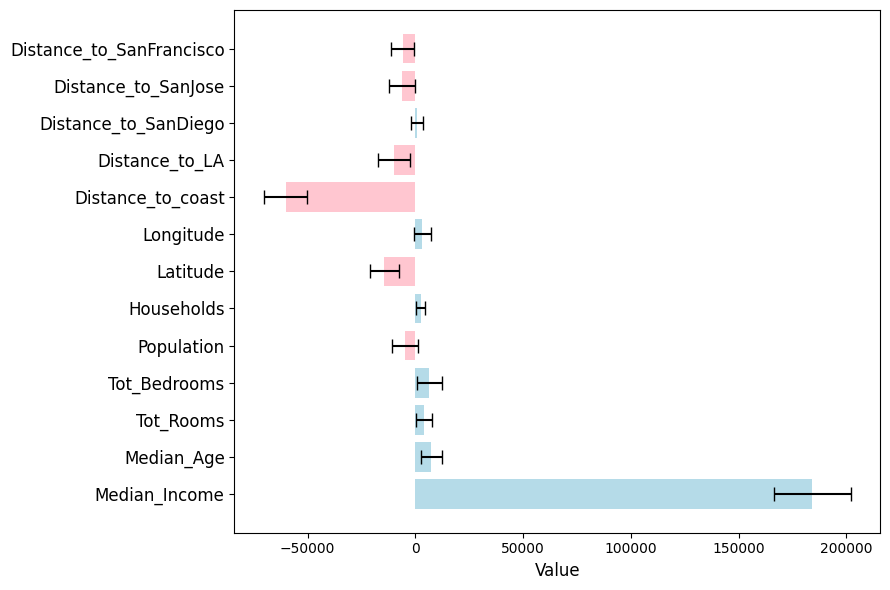

In [512]:

stacked_shap_values_50 = np.vstack([gbt_explanation_50_shap[i].values for i in range(len(gbt_explanation_50_shap))])
mean_shap_values_50 = np.mean(stacked_shap_values_50, axis=0)
sd_shap_values_50 = np.std(stacked_shap_values_50, axis=0)
shap_features = X_test.loc[[10]].columns.tolist()

feature_ids = range(len(mean_shap_values_50))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_shap_values_50, xerr=sd_shap_values_50, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, shap_features, fontsize=12)
plt.xlabel("Value", fontsize=12)
plt.tight_layout()
plt.show()